In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

Dataset Features:

Pregnancies: To express the Number of pregnancies
Glucose: To express the Glucose level in blood
BloodPressure: To express the Blood pressure measurement
SkinThickness: To express the thickness of the skin
Insulin: To express the Insulin level in blood
BMI: To express the Body mass index
DiabetesPedigreeFunction: To express the Diabetes percentage
Age: To express the age
Outcome: To express the final result 1 is YES o is NO

In [3]:
# Load training and testing datasets
train_df = pd.read_csv("diabetes-dataset/Training.csv")
test_df = pd.read_csv("diabetes-dataset/Testing.csv")


# Combine both datasets into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)

# Reset index to ensure it's ordered correctly
df.reset_index(drop=True, inplace=True)

In [4]:
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2768 non-null   int64  
 1   Glucose                   2768 non-null   int64  
 2   BloodPressure             2768 non-null   int64  
 3   SkinThickness             2768 non-null   int64  
 4   Insulin                   2768 non-null   int64  
 5   BMI                       2768 non-null   float64
 6   DiabetesPedigreeFunction  2768 non-null   float64
 7   Age                       2768 non-null   int64  
 8   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 194.8 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2768.0,3.822616,3.305432,0.000,1.000,3.00,6.00000,17.00
Glucose,2768.0,121.421965,31.721258,0.000,100.000,117.00,142.00000,199.00
BloodPressure,2768.0,68.980491,19.133100,0.000,64.000,71.00,80.00000,122.00
SkinThickness,2768.0,20.549494,15.779713,0.000,0.000,23.00,33.00000,99.00
Insulin,2768.0,79.853324,115.655771,0.000,0.000,36.00,129.00000,846.00
BMI,2768.0,31.976590,7.760540,0.000,27.175,32.10,36.50000,67.10
DiabetesPedigreeFunction,2768.0,0.486277,0.357403,0.078,0.248,0.38,0.64525,2.42
Age,2768.0,32.923049,11.362964,21.000,24.000,29.00,40.00000,81.00
Outcome,2768.0,0.380419,0.485578,0.000,0.000,0.00,1.00000,1.00


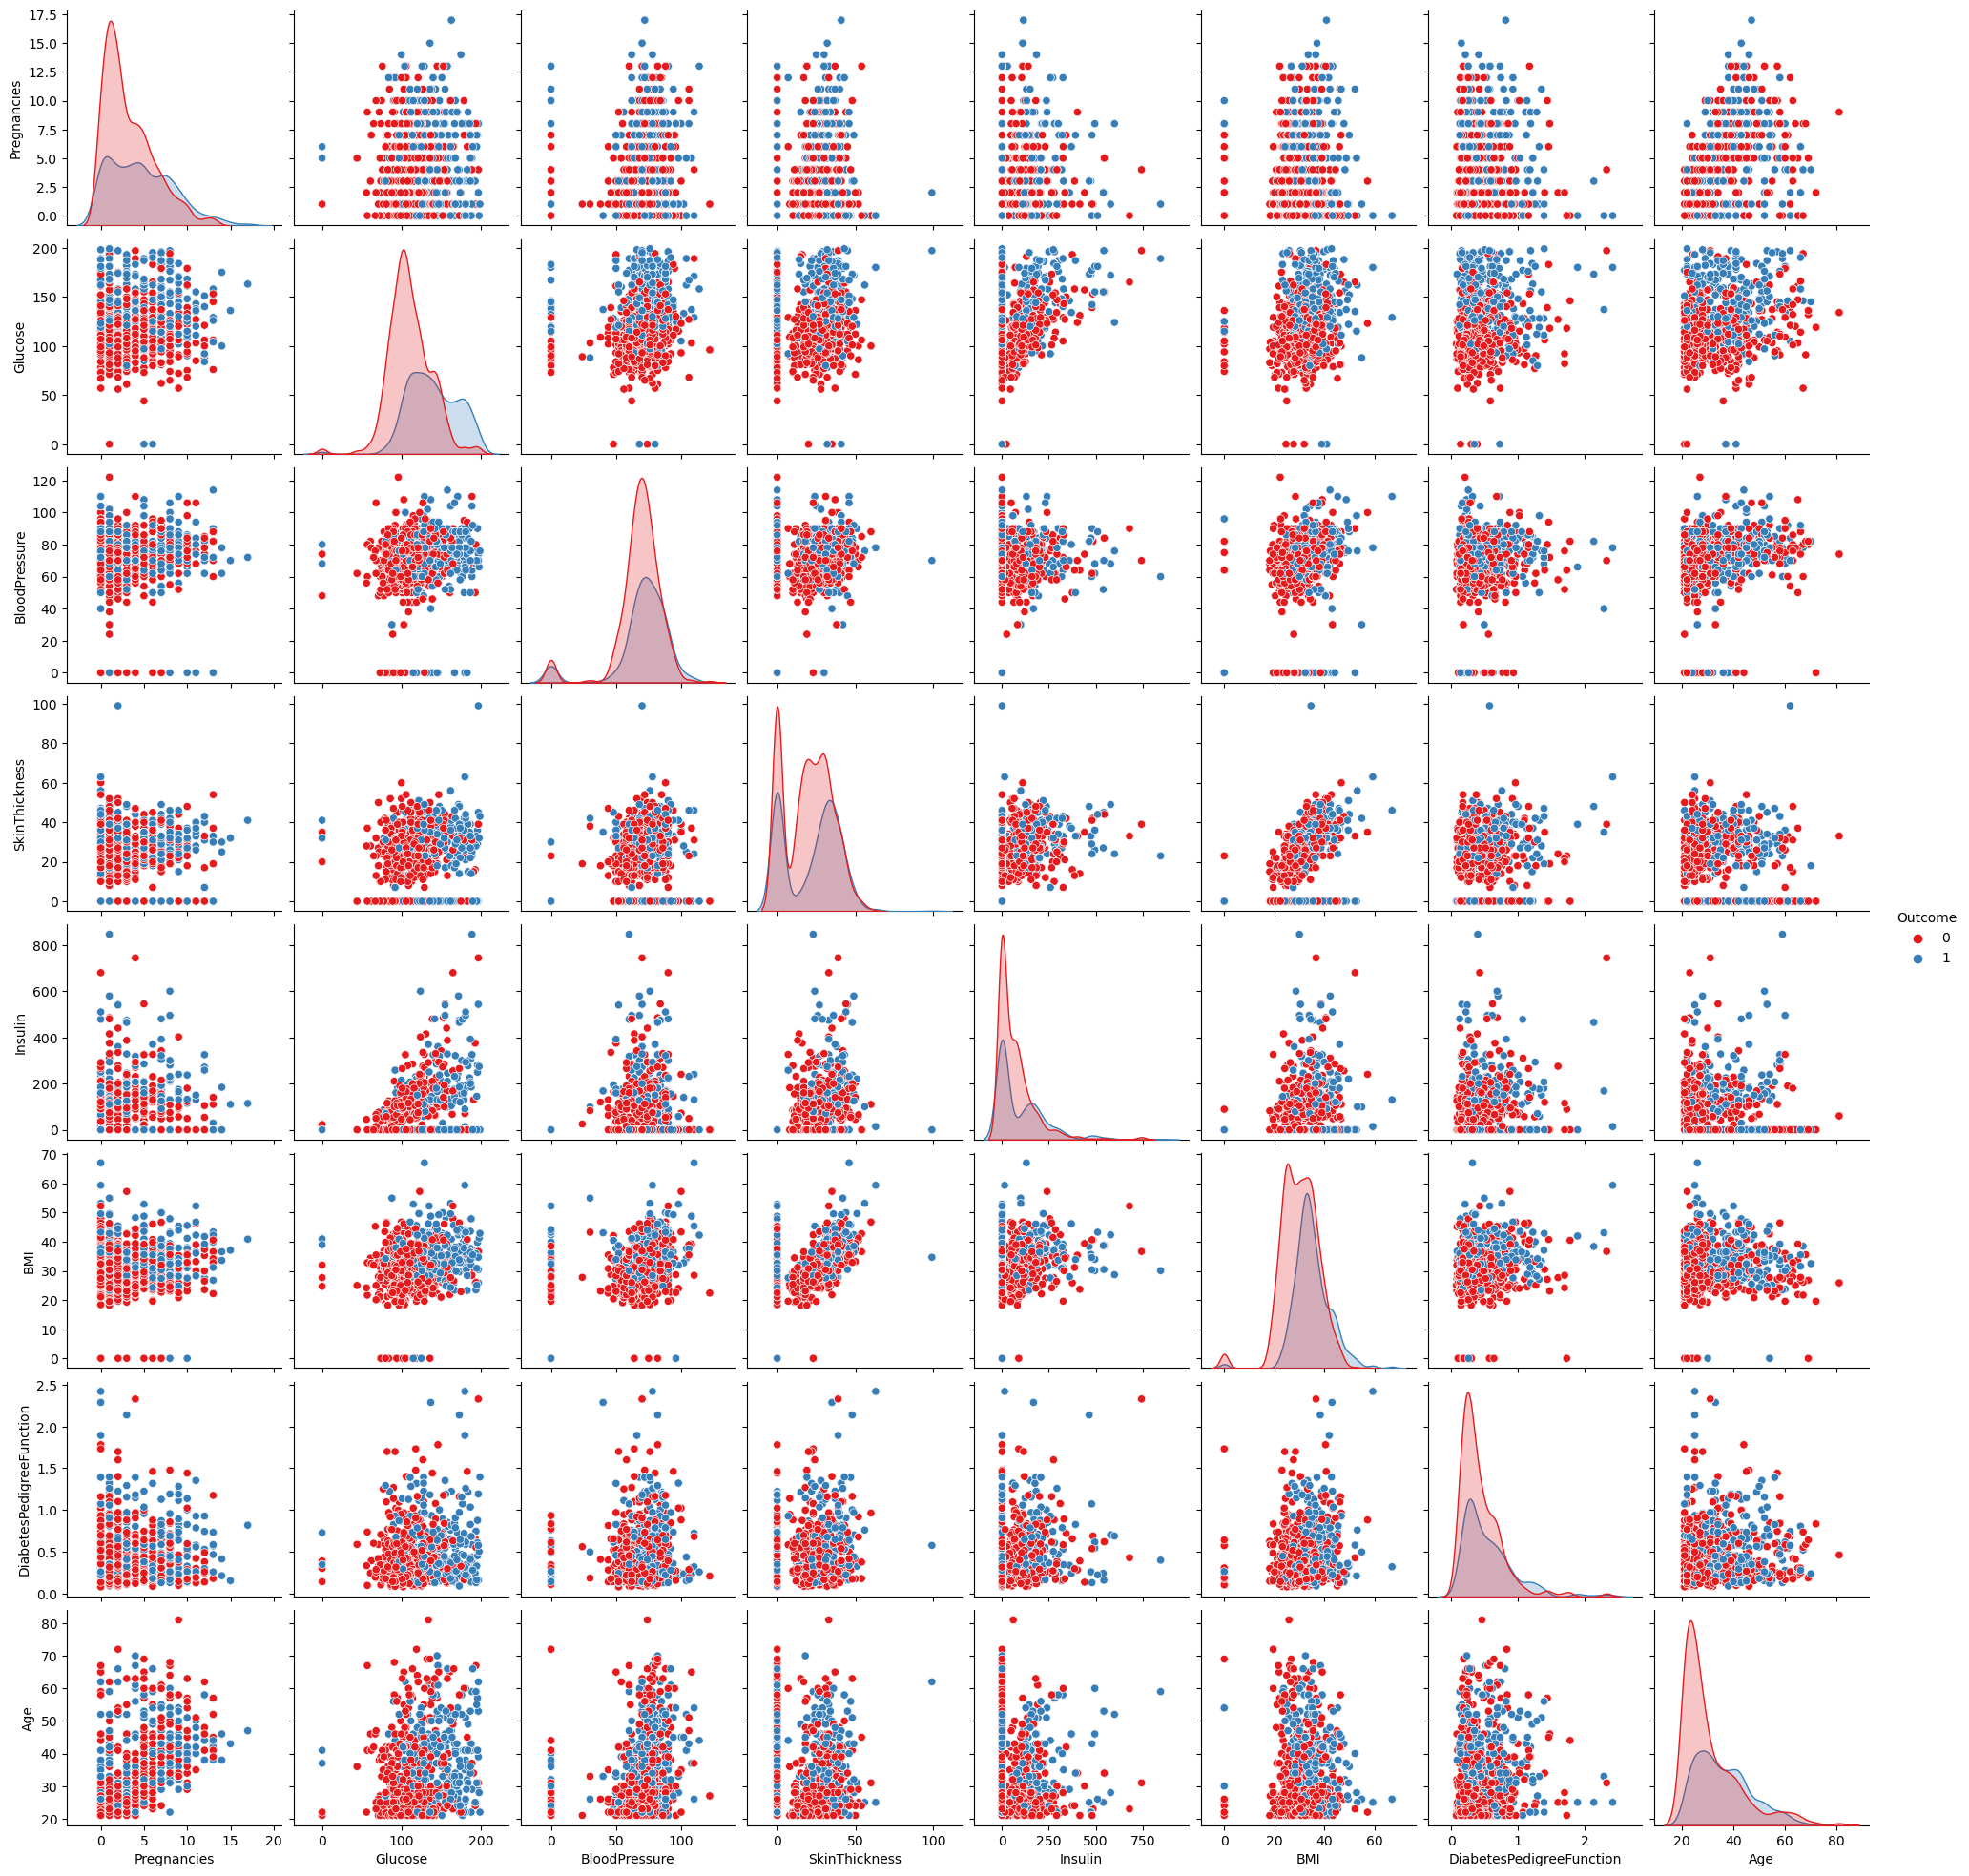

In [7]:
sns.pairplot(df, hue='Outcome',palette ='Set1')

# Unvariate Analysis

# Numerical variables

In [8]:
numerical_columns = df.drop(columns=['Outcome']).columns
df_numerical = df[numerical_columns]

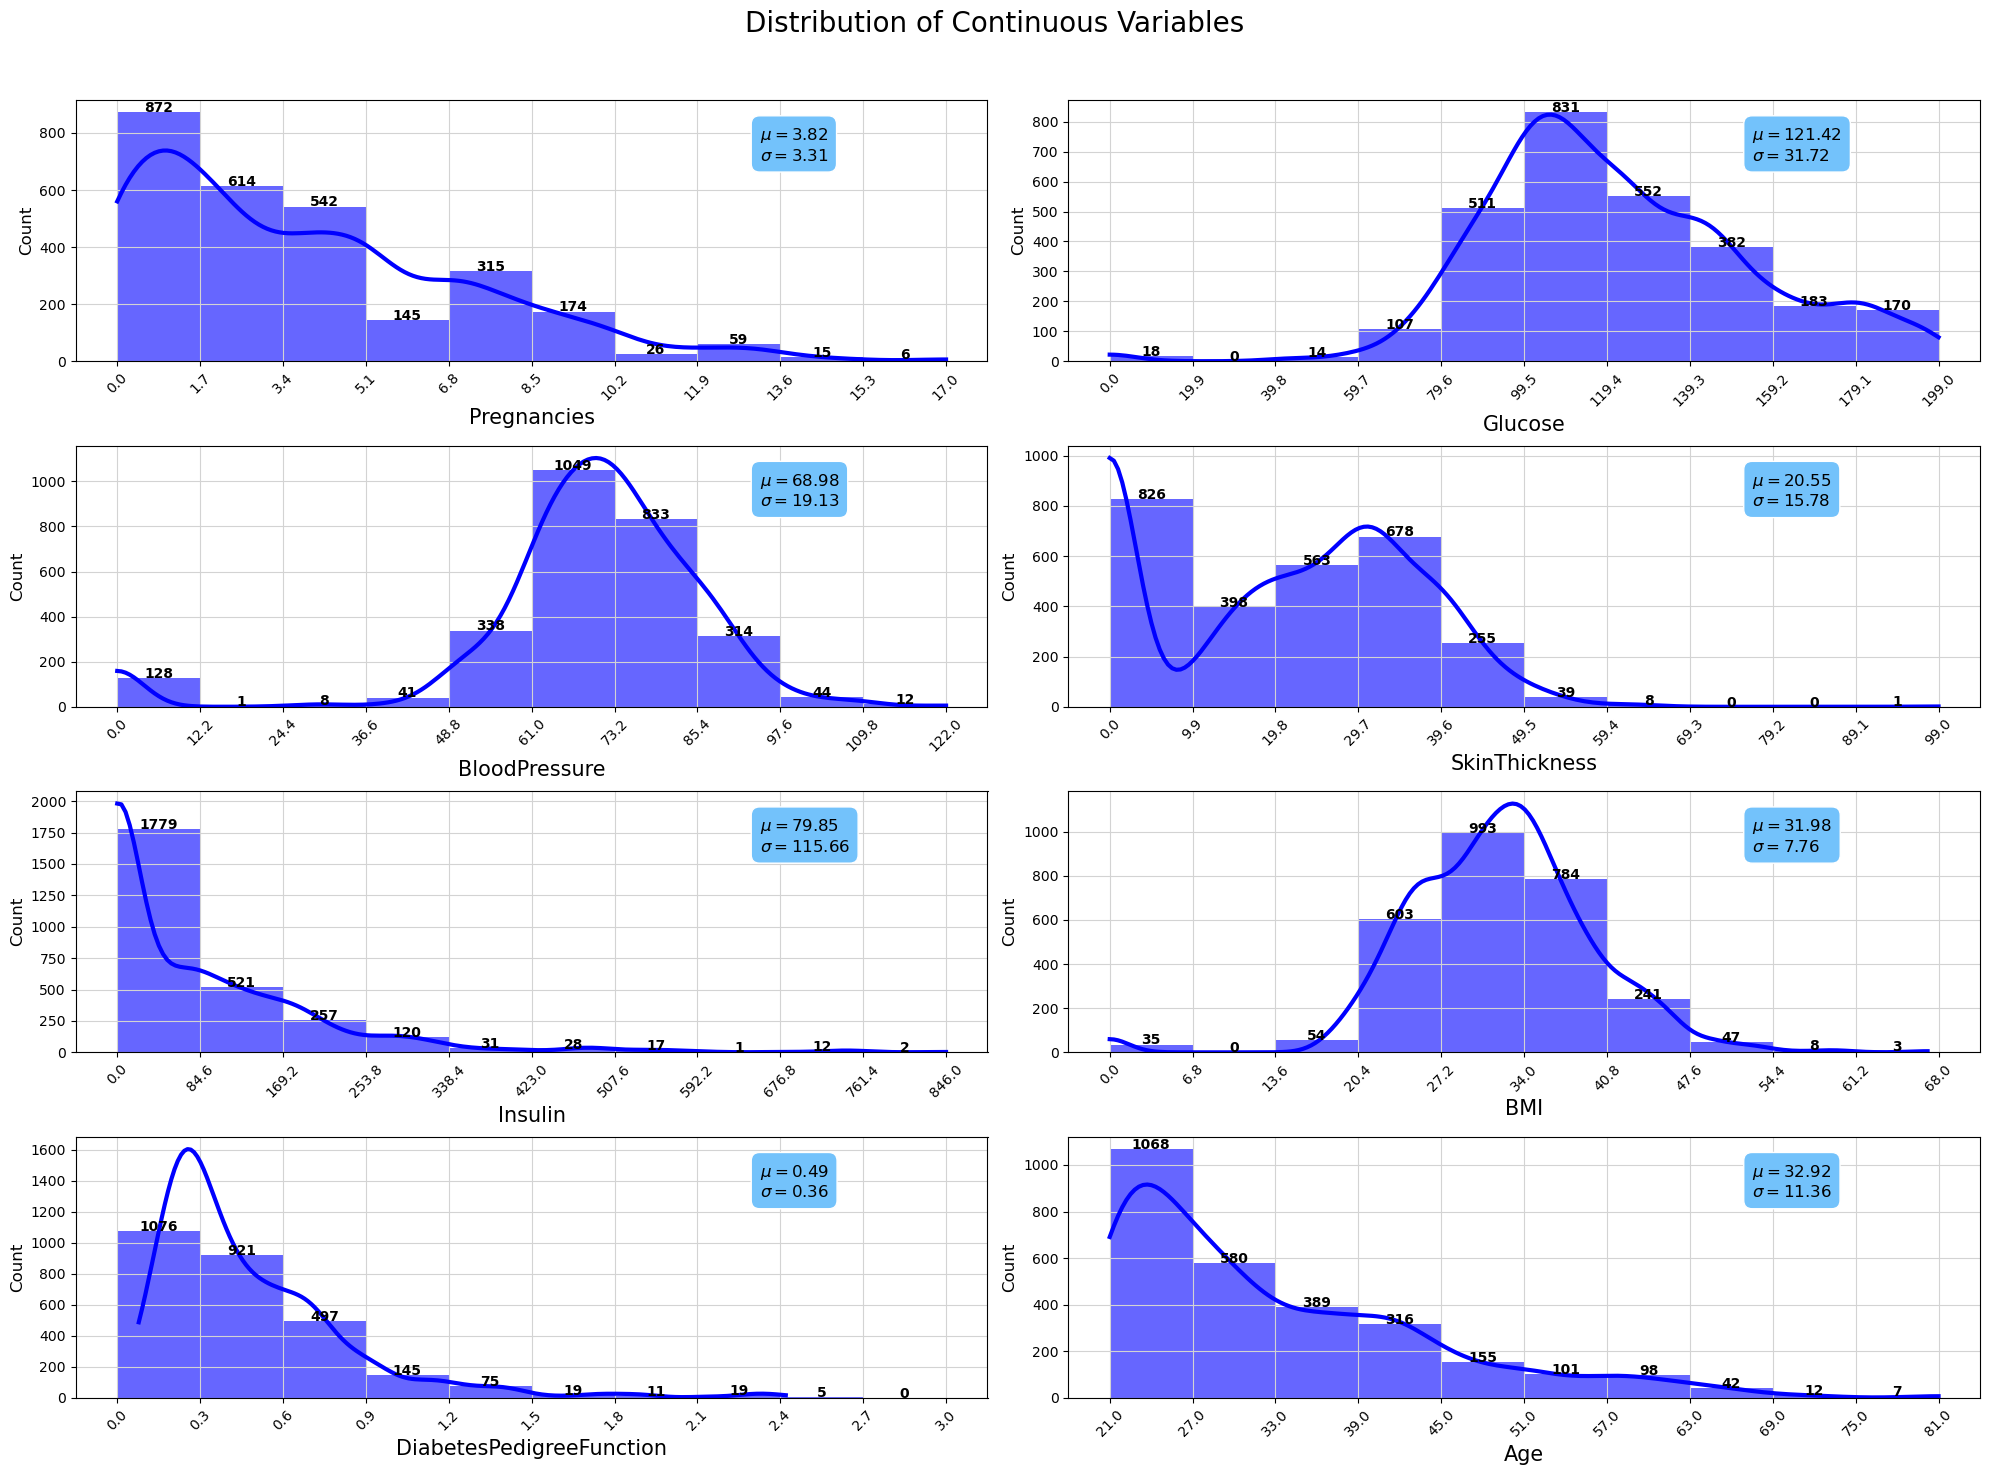

In [9]:
# Set up the subplot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_numerical.columns):
    x = i // 2
    y = i % 2
    values, bin_edges = np.histogram(df_numerical[col], 
                                     range=(np.floor(df[col].min()), np.ceil(df_numerical[col].max())))
    
    graph = sns.histplot(data=df_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='blue', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_numerical[col].mean(),
        r'$\sigma=%.2f$' % df_numerical[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='black', bbox=dict(boxstyle='round', facecolor='#73c2fb', edgecolor='white', pad=0.5))


plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Bivariate Analysis

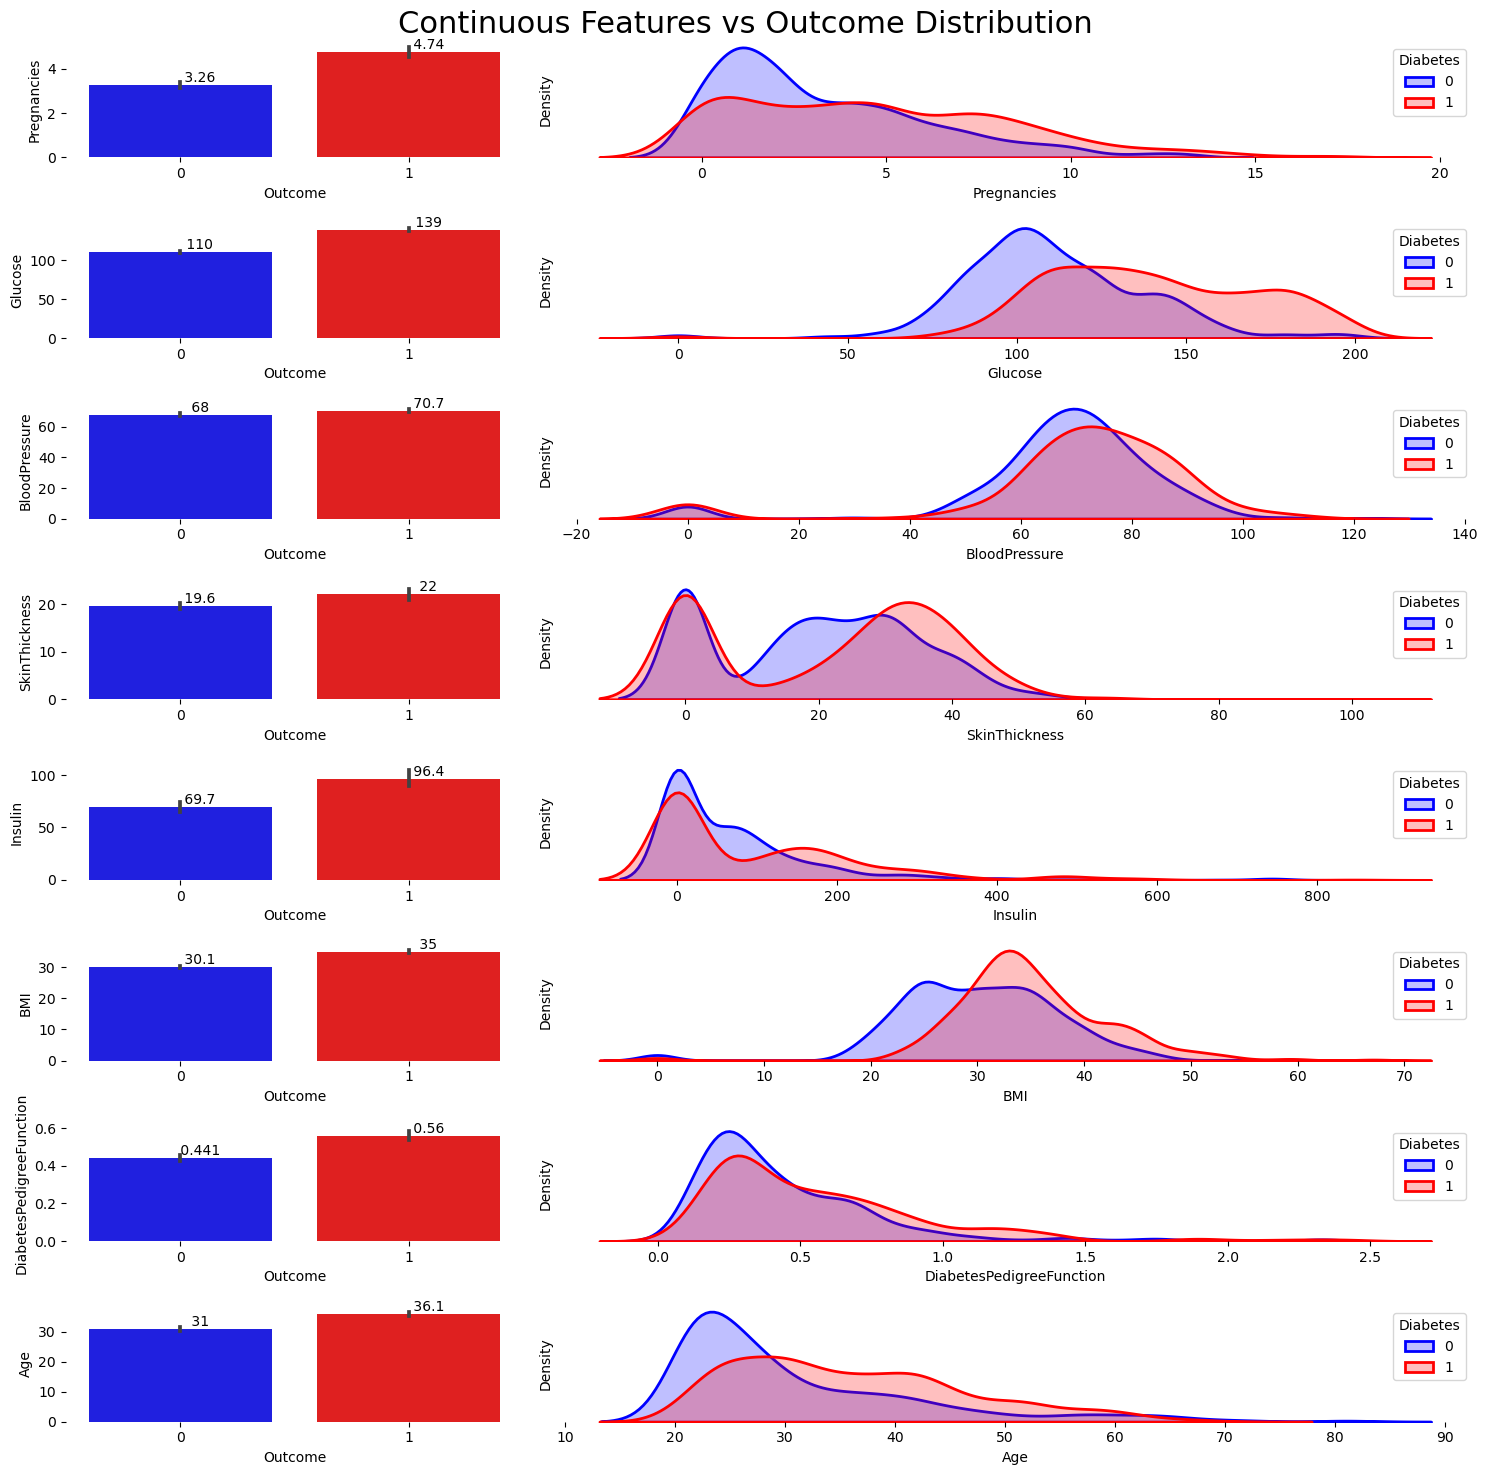

In [10]:
# Set color palette
sns.set_palette(['blue', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(numerical_columns), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(numerical_columns):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="Outcome", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["Outcome"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["Outcome"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Diabetes', loc='upper right')

    
    # Remove outer border barplot
    for spine in ax[i,0].spines.values():
        spine.set_visible(False)
        
    # Remove outer border kde plor
    for spine in ax[i,1].spines.values():
        spine.set_visible(False)
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Outcome Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

# Data Preprocessing

# Irrelevant Features Removal

# Missing Value Treatment

In [11]:
df.isnull().sum().sum()

0

# Handle Noisy Data

In [12]:
# Analyze noisy data
noisy_data = {
    'BloodPressure':  df[df['BloodPressure'] == 0],
    'SkinThickness':   df[df['SkinThickness'] == 0],
    'Insulin': df[df['Insulin'] == 0],
    'BMI':   df[df['BMI'] == 0],
}

noisy_data_count = {key: len(value) for key, value in noisy_data.items()}
noisy_data_count

{'BloodPressure': 128, 'SkinThickness': 810, 'Insulin': 1333, 'BMI': 35}

In [13]:
# Remove rows with 0 entries
df = df[df['BloodPressure'] != 0]
df = df[df['SkinThickness'] != 0]
df = df[df['Insulin'] != 0]
df = df[df['BMI'] != 0]

In [14]:
# Reset the index
df.reset_index(drop=True, inplace=True)

# Check if the noisy data has been handled
noisy_data_handled = {
    'BloodPressure':  df[df['BloodPressure'] == 0],
    'SkinThickness':   df[df['SkinThickness'] == 0],
    'Insulin': df[df['Insulin'] == 0],
    'BMI':   df[df['BMI'] == 0],
}

noisy_data_handled_count = {key: len(value) for key, value in noisy_data_handled.items()}
noisy_data_handled_count

{'BloodPressure': 0, 'SkinThickness': 0, 'Insulin': 0, 'BMI': 0}

# Outlier Treatment

In [15]:
numerical_columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [16]:
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

Pregnancies                 42
Glucose                      5
BloodPressure               32
SkinThickness                5
Insulin                     79
BMI                         15
DiabetesPedigreeFunction    65
Age                         70
dtype: int64

# Check Imbalanced Data

In [17]:
df['Outcome'].value_counts()

Outcome
0    917
1    512
Name: count, dtype: int64

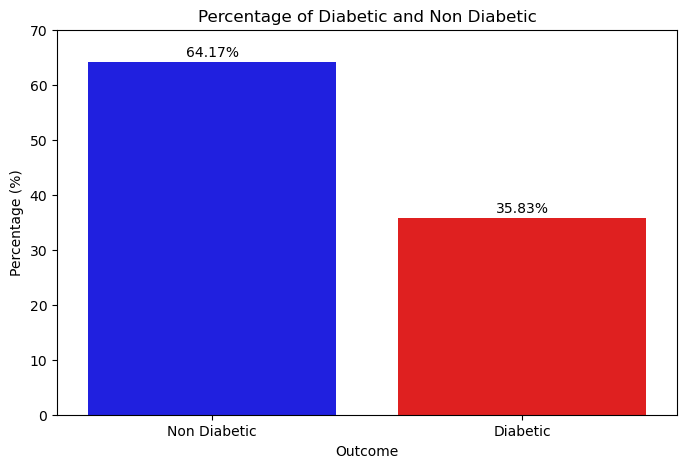

In [18]:
# Calculating the percentage of each class
percentage = df['Outcome'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage )
plt.title('Percentage of Diabetic and Non Diabetic')
plt.xlabel('Outcome')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Non Diabetic', 'Diabetic'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

# Split the Dataset

In [19]:
# Define the features (X) and the output labels (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome'] 
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(pd.Series(y_train).value_counts(normalize = True))
print(pd.Series(y_test).value_counts(normalize = True))

Outcome
0    0.641295
1    0.358705
Name: proportion, dtype: float64
Outcome
0    0.643357
1    0.356643
Name: proportion, dtype: float64


# Decision Tree Model

In [20]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

# DT Hyperparameter Tuning

In [21]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 2}, 'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 4}


# DT Model Evaluation

In [22]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [23]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap resembling an apple (red theme)
    apple_red = LinearSegmentedColormap.from_list('apple_red', [(0, '#FF0000'), (1, '#FFFFFF')])
    apple_red_r = apple_red.reversed() 
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=apple_red_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('#FF0000')
    plt.tight_layout()
    plt.show()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       733
           1       1.00      1.00      1.00       410

    accuracy                           1.00      1143
   macro avg       1.00      1.00      1.00      1143
weighted avg       1.00      1.00      1.00      1143


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       184
           1       0.95      0.92      0.94       102

    accuracy                           0.95       286
   macro avg       0.95      0.95      0.95       286
weighted avg       0.95      0.95      0.95       286



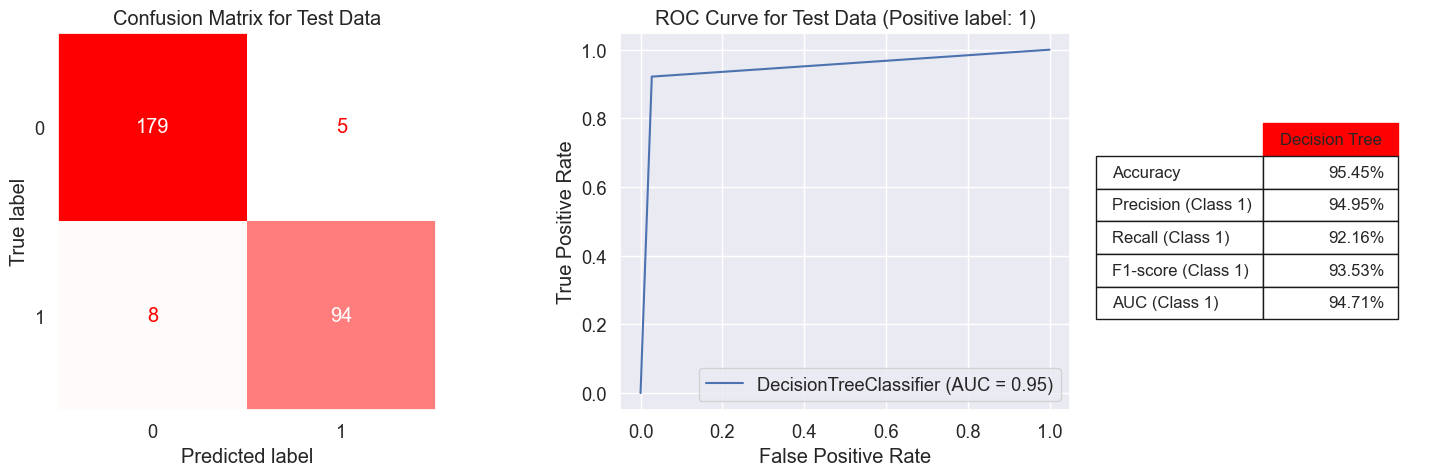

In [24]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

In [25]:
# Save the final performance of DT classifier
dt_result = metrics_calculator(best_dt, X_test, y_test, 'Decision Tree')
dt_result

,Decision Tree
Accuracy,95.45%
Precision (Class 1),94.95%
Recall (Class 1),92.16%
F1-score (Class 1),93.53%
AUC (Class 1),94.71%


# Random Forest Model

In [26]:
# Define the base RF model
rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

# RF Hyperparameter Tuning

In [27]:
param_grid_rf = {
    'n_estimators': [100, 150],
    'criterion': ['entropy'],
    'max_depth': [16, 18],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [28]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)

In [29]:
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}


# RF Model Evaluation


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       733
           1       1.00      1.00      1.00       410

    accuracy                           1.00      1143
   macro avg       1.00      1.00      1.00      1143
weighted avg       1.00      1.00      1.00      1143


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       184
           1       0.98      0.95      0.97       102

    accuracy                           0.98       286
   macro avg       0.98      0.97      0.97       286
weighted avg       0.98      0.98      0.98       286



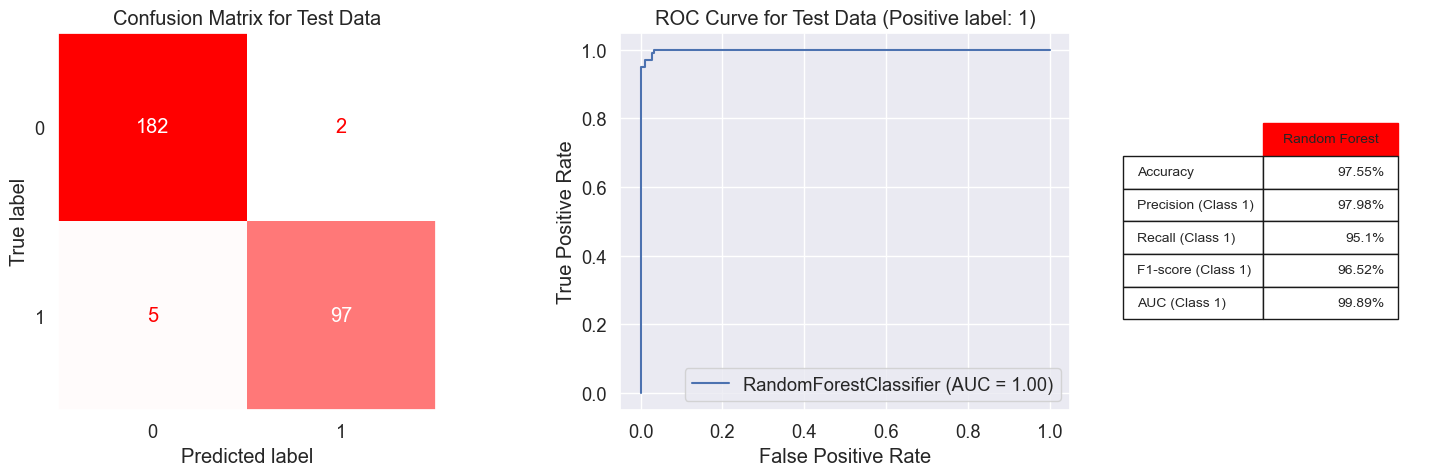

In [30]:
model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

In [31]:
# Save the final performance of RF classifier
rf_result = metrics_calculator(best_rf, X_test, y_test, 'Random Forest')
rf_result

,Random Forest
Accuracy,97.55%
Precision (Class 1),97.98%
Recall (Class 1),95.1%
F1-score (Class 1),96.52%
AUC (Class 1),99.89%


# XGBoost Model 

In [32]:
# Define the model
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

# XGBoost Hyperparameter Tuning

In [33]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [34]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)

In [35]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 350, 'scale_pos_weight': 1, 'subsample': 0.7}


# XGBoost Model Evaluation


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       733
           1       1.00      1.00      1.00       410

    accuracy                           1.00      1143
   macro avg       1.00      1.00      1.00      1143
weighted avg       1.00      1.00      1.00      1143


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       184
           1       0.98      0.94      0.96       102

    accuracy                           0.97       286
   macro avg       0.97      0.97      0.97       286
weighted avg       0.97      0.97      0.97       286



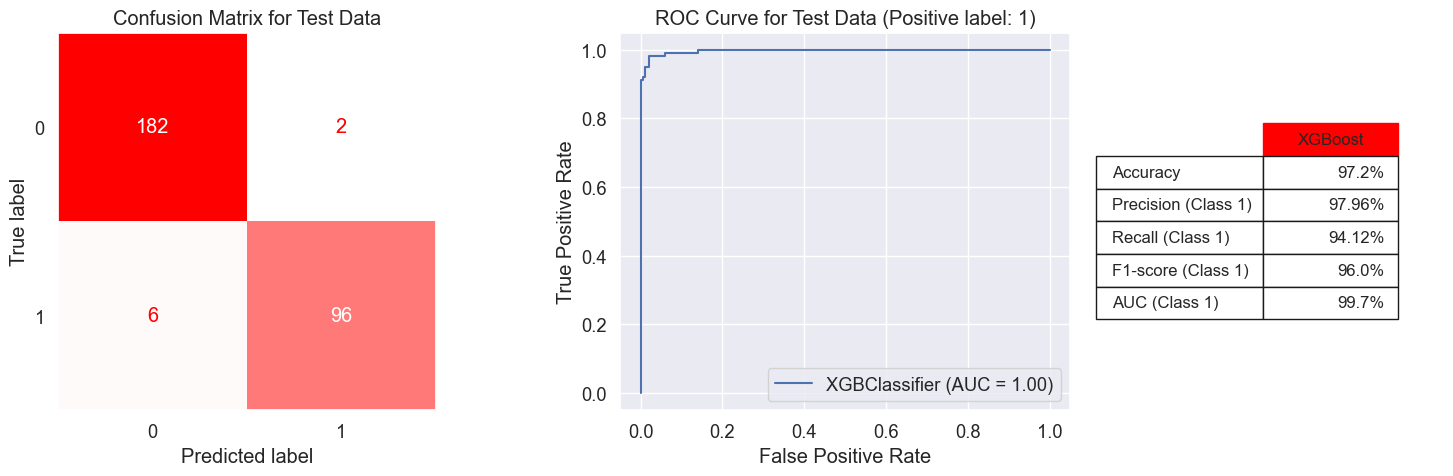

In [36]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

In [37]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(best_xgb, X_test, y_test, 'XGBoost')
xgb_result

,XGBoost
Accuracy,97.2%
Precision (Class 1),97.96%
Recall (Class 1),94.12%
F1-score (Class 1),96.0%
AUC (Class 1),99.7%


# Conclusion

In [38]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([dt_result, rf_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score (class 1) values
results.sort_values(by='Recall (Class 1)', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color:  #cce5ff', subset='Recall (Class 1)')

,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1),AUC (Class 1)
Random Forest,97.55%,97.98%,95.1%,96.52%,99.89%
XGBoost,97.2%,97.96%,94.12%,96.0%,99.7%
Decision Tree,95.45%,94.95%,92.16%,93.53%,94.71%


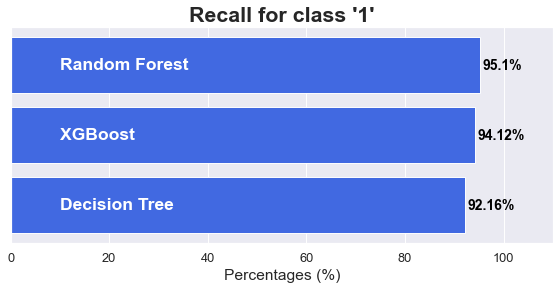

In [39]:
# Prepare values
results.sort_values(by='Recall (Class 1)', ascending=True, inplace=True)
f1_scores = results['Recall (Class 1)'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 4), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='black')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("Recall for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()